In [31]:
# importing libraries
import os
import numpy as np
import random
import torch
import torchvision
import pytorch_lightning as pl
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import wandb
from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import torch.nn.functional as F
import gc
import matplotlib.pyplot as plt
from io import BytesIO

In [2]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_key")

os.environ['WANDB_API_KEY'] = secret_value_0

In [3]:
# Custom Dataset for iNaturalist

class iNaturalistDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(data_dir))

        # storing all labels, iamge paths
        for label, class_name in enumerate(self.class_names):
            class_dir = os.path.join(data_dir, class_name)
            for image_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, image_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    # get a particular image
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
# Data Preprocessing and Augmentation
def get_transforms(data_augmentation=True):
    if data_augmentation:
        return transforms.Compose([
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1,hue=0.05),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
    else:
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [20]:
class SimpleCNN(pl.LightningModule):
    def __init__(self, convFilters, filterSizes, activationFn, useBatchNorm, dropoutRate,
                 optimizerType, learningRate, weightDecay, denseFeatures, numClasses=10):
        super().__init__()
        self.save_hyperparameters()  # Save hyperparameters for easy access and logging

        # Define the loss function here
        self.lossFn = nn.CrossEntropyLoss()

        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.test_accuracy=[]
        self.test_loss=[]
        
        self.convBlocks = nn.ModuleList() 
        in_channels = 3  

        # Construct convolutional blocks based on given filters and kernel sizes
        for out_channels, k in zip(convFilters, filterSizes):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=k, stride=1, padding=k // 2)]
            if useBatchNorm:
                layers.append(nn.BatchNorm2d(out_channels))  # Add BatchNorm if enabled
            layers.append(activationFn())  # Add activation function (ReLU, GELU, etc.)
            layers.append(nn.MaxPool2d(2)) 
            if dropoutRate > 0:
                layers.append(nn.Dropout2d(dropoutRate))
            self.convBlocks.append(nn.Sequential(*layers)) 
            in_channels = out_channels  # Set input channels for next block

        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 224, 224)
            for block in self.convBlocks:
                dummy_input = block(dummy_input)
            self.flattened_size = dummy_input.view(1, -1).shape[1]  
        # Fully connected (dense) layer
        self.fc = nn.Linear(self.flattened_size, denseFeatures)
        self.fc_activation = activationFn()  # Activation after dense layer
        self.dropout = nn.Dropout(dropoutRate) if dropoutRate > 0 else nn.Identity()  # Optional dropout
        self.outputLayer = nn.Linear(denseFeatures, numClasses)  # Final classification layer

        # Cross-entropy loss for multi-class classification
        self.lossFn = nn.CrossEntropyLoss()

    def forward(self, x):
        # Pass input through convolutional blocks
        for block in self.convBlocks:
            x = block(x)
        x = torch.flatten(x, start_dim=1)  # Flatten for fully connected layer
        x = self.fc_activation(self.fc(x))  # Apply dense layer and activation
        x = self.dropout(x)  # Apply dropout (if any)
        return self.outputLayer(x)  # Output raw class scores (logits)
        
    def training_step(self, batch, batchIdx):
        # Training logic: forward pass + compute loss
        images, labels = batch
        logits = self(images)
        loss = self.lossFn(logits, labels)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == labels).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", acc, prog_bar=True)
        return {'loss': loss,'acc':acc}

    def validation_step(self, batch, batchIdx):
        # Validation logic: compute loss and accuracy
        images, labels = batch
        logits = self(images)
        loss = self.lossFn(logits, labels)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == labels).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acc, prog_bar=True)
        return {'loss': loss,'acc':acc}

    def test_step(self, batch, batch_idx):
        # Validation logic: compute loss and accuracy
        images, labels = batch
        logits = self(images)
        loss = self.lossFn(logits, labels)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == labels).float().mean()
        #storing accuracies to print afterwards
        self.test_accuracy.append(acc.item())
        self.test_loss.append(loss.item())
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_accuracy", acc, prog_bar=True)

    def on_test_epoch_end(self):
        #printing Final Test accuracy and loss
        avg_accuracy = sum(self.test_accuracy) / len(self.test_accuracy)
        avg_loss = sum(self.test_loss) / len(self.test_loss)
        print(f"\nFinal Test Accuracy: {avg_accuracy:.4f}")
        print(f"Final Test Loss: {avg_loss:.4f}")

    def evaluate(self, dataloader, stage="train"):
        self.eval()
        correct = 0
        total = 0
        total_loss = 0.0
        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.to(self.device), y.to(self.device)
                logits = self(x)
                loss = F.cross_entropy(logits, y)
                preds = torch.argmax(logits, dim=1)
    
                correct += (preds == y).sum().item()
                total += y.size(0)
                total_loss += loss.item() * y.size(0)
    
        avg_loss = total_loss / total
        accuracy = correct / total
        print(f"{stage.capitalize()} Accuracy: {accuracy:.4f}, {stage.capitalize()} Loss: {avg_loss:.4f}")

    
    # Define optimizer based on provided hyperparameters
    def configure_optimizers(self):
        if self.hparams.optimizerType == 'adam':
            return torch.optim.Adam(self.parameters(), lr=self.hparams.learningRate, weight_decay=self.hparams.weightDecay)
        elif self.hparams.optimizerType == 'nadam':
            return torch.optim.NAdam(self.parameters(), lr=self.hparams.learningRate, weight_decay=self.hparams.weightDecay)
        elif self.hparams.optimizerType == 'rmsprop':
            return torch.optim.RMSprop(self.parameters(), lr=self.hparams.learningRate, weight_decay=self.hparams.weightDecay)
        else:
            raise ValueError(f"{self.hparams.optimizerType} optimizer not implemented")  # Handle unknown optimizer

In [6]:
def load_data(batch_size, data_augmentation=True):
    """
    Load and prepare the iNaturalist dataset with data augmentation and parallelized data loading.
    """
    # Get image transformation pipeline
    transform = get_transforms(data_augmentation)

    # Load dataset
    dataset = iNaturalistDataset('/kaggle/input/inaturalist_12K/train', transform)

    # Split into training (80%) and validation (20%) sets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    num_workers=0
    if torch.cuda.is_available():
        num_workers = min(4, os.cpu_count())
    else:
        num_workers = 0
    pin_memory = torch.cuda.is_available()

    train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory=pin_memory)

    return train_loader, val_loader


In [7]:
activation_functions = {
    'relu': torch.nn.ReLU,
    'gelu': torch.nn.GELU,
    'silu': torch.nn.SiLU,
    'mish': None  # Special case for Mish (since it's not built-in)
}

def get_activation_fn(config_activation_fn):
    # Handled 'mish' as a special case (it's not a built-in PyTorch activation function)
    if config_activation_fn.lower() == 'mish':
        class Mish(torch.nn.Module):
            def forward(self, x):
                return x * torch.tanh(torch.nn.functional.softplus(x))
        return Mish
    # Otherwise, used the dictionary for built-in activations
    elif config_activation_fn.lower() in activation_functions:
        return activation_functions[config_activation_fn.lower()]
    else:
        raise ValueError(f"Activation function {config_activation_fn} not recognized.")

In [8]:
## running on sample params

# Define hyperparameters
convFilters = [256, 128, 64, 32,16]
filterSizes = [3, 5, 3, 5, 3]
activationFn = get_activation_fn('silu')
useBatchNorm = False
dropoutRate = 0.3
optimizerType = 'adam'
learningRate = 0.0001
weightDecay = 0
denseFeatures = 512
numClasses = 10  # Adjust for the number of classes in iNaturalist
batch_size = 64  # Batch size for data loading

# Initialize the model
model = SimpleCNN(convFilters=convFilters,filterSizes=filterSizes,activationFn=activationFn,useBatchNorm=useBatchNorm,dropoutRate=dropoutRate,
                  optimizerType=optimizerType,learningRate=learningRate,weightDecay=weightDecay,denseFeatures=denseFeatures,numClasses=numClasses)

# Load data
train_loader, val_loader = load_data(batch_size, data_augmentation=True)

# --- EARLY STOPPING ---
early_stop_callback = EarlyStopping(
    monitor="val_acc",
    patience=5,
    verbose=True,
    mode="max"
)

devices = 0
# Set up the PyTorch Lightning Trainer
if torch.cuda.is_available():
    accelerator = "gpu"
    devices     = torch.cuda.device_count() 
else:
    accelerator = "cpu"
    devices     = 1 

trainer = pl.Trainer(precision='16-mixed',max_epochs = 1,accelerator = accelerator,devices =devices,
                     callbacks=[early_stop_callback])
# Train the model
trainer.fit(model, train_loader, val_loader)
train_metrics = trainer.callback_metrics
val_metrics = trainer.validate(model, dataloaders=val_loader, verbose=False)

In [9]:
# Hyperparameter sweep configuration
sweep_config = {
    'method': 'random',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        # Convolutional layer configurations
        'convFilters': {'values': [[32]*5, [16, 32, 64, 128, 256], [256, 128, 64, 32,16], [128, 128, 64, 64, 32]]},
        'filterSizes': {'values': [[3, 3, 3, 3, 3], [5, 5, 5, 5, 5], [3, 5, 3, 5, 3]]},
        'useBatchNorm': {'values': [True, False]},
        'dropoutRate': {'values': [0.2, 0.3]},
        'optimizerType': {'values': ['adam', 'nadam', 'rmsprop']},
        'learningRate': {'values': [1e-2, 1e-3, 1e-4]},
        'weightDecay': {'values': [0.0, 0.0005, 0.005]},
        'activationFn': {'values': ['relu', 'gelu', 'silu', 'mish']},
        'dataAugmentation': {'values': [True, False]},
        'denseFeatures': {'values': [ 256, 512, 1024]},
        'batchSize': {'values': [32, 64]},
        'maxEpochs': {'values': [10]}
    }
}

Divding Hyperparameters into 2 parts 

Phase 1: Model Architecture
Focus on the structure of the network and the architectural choices (convFilters, filterSizes, activationFn). These choices directly impact model performance and can have a significant effect on training speed and accuracy.

Phase 2: Training Hyperparameters
After deciding on the architecture, fine-tune the training parameters (optimizer, learning rate, batch size, etc.) that affect the convergence and performance stability.

In [10]:
# Phase 1 Sweep Config (Model Architecture)
sweep_config_phase1 = {
    'method': 'random',  # Use random search for broad exploration
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        # Convolutional layer configurations (focusing on architecture-related choices)
        'convFilters': {'values': [[32]*5, [16,32, 64, 128, 256], [256, 128, 64, 32,16], [128, 128, 64, 64, 32]]},
        'filterSizes': {'values': [[3, 3, 3, 3, 3], [5, 5, 5, 5, 5], [3, 5, 3, 5, 3]]},
        'activationFn': {'values': ['relu', 'gelu', 'silu', 'mish']},
        'useBatchNorm': {'values': [True, False]},  # To explore if batch normalization improves the performance
        'dropoutRate': {'values': [0.2, 0.3]},  # To check the impact of dropout
        'dataAugmentation': {'values': [True, False]},  # Explore data augmentation impact
        'denseFeatures': {'values': [256, 512, 1024]},  # Exploring different dense layer sizes
    }
}


In [11]:
def train_model_phase1():
    # Clearing memory before starting each run
    gc.collect()
    torch.cuda.empty_cache()

    run = wandb.init(project="da6401_Assignment2", config=sweep_config_phase1)
    config = wandb.config

    # Construct the run name based on phase 1 parameters
    run_name = f"activationFn={config['activationFn']}_convFilters={config['convFilters']}_" \
               f"dataAugmentation={config['dataAugmentation']}_denseFeatures={config['denseFeatures']}_" \
               f"dropoutRate={config['dropoutRate']}_filterSizes={config['filterSizes']}_" \
               f"useBatchNorm={config['useBatchNorm']}"

    run.name = run_name  # Set the run name

    activation_fn = get_activation_fn(config.activationFn)

    # Initialize the model with phase 1-configured parameters
    model = SimpleCNN(
        convFilters=config.convFilters,
        filterSizes=config.filterSizes,
        activationFn=activation_fn,
        useBatchNorm=config.useBatchNorm,
        dropoutRate=config.dropoutRate,
        optimizerType="adam",
        learningRate=1e-3,     # Default learning rate for phase 1
        weightDecay=0.0,       # Default weight decay for phase 1
        denseFeatures=config.denseFeatures,
        numClasses=10
    )

    batch_size = 64
    maxEpochs=10

    # Load train and validation datasets
    train_loader, val_loader = load_data(batch_size, config.dataAugmentation)
    wandb_logger = WandbLogger(log_model=True)

    # Early Stopping (for Phase 1)
    early_stop_callback = EarlyStopping(
        monitor="val_acc",
        patience=3,
        verbose=True,
        mode="max",
        check_on_train_epoch_end=True
    )

    # Set up PyTorch Lightning Trainer
    devices = 1
    if torch.cuda.is_available():
        accelerator = "gpu"
        devices = torch.cuda.device_count()
    else:
        accelerator = "cpu"
        devices = 1

    trainer = pl.Trainer(
        precision='16-mixed',
        max_epochs=maxEpochs,
        accelerator=accelerator,
        logger=wandb_logger,
        devices=devices,
        callbacks=[early_stop_callback]
    )

    # Train model
    trainer.fit(model, train_loader, val_loader)

    # Final evaluation
    train_metrics = trainer.callback_metrics
    val_metrics = trainer.validate(model, dataloaders=val_loader, verbose=False)

    # Log final metrics for sweep to work
    wandb.log({
        "train_accuracy": train_metrics["train_acc"].item(),
        "train_loss": train_metrics["train_loss"].item(),
        "val_accuracy": val_metrics[0]['val_acc'],  # Required by sweep
        "val_loss": val_metrics[0]['val_loss']
    })
    run.finish()

In [12]:
# Run the sweep 
sweep_id = wandb.sweep(sweep_config_phase1, project="da6401_Assignment2")
wandb.agent(sweep_id, function=train_model_phase1, count=50)

In [13]:
# Phase 2 Sweep Config (Training Hyperparameters)
sweep_config_phase2 = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        # Training hyperparameters (fine-tuning the training process)
        #from phase1
        'convFilters': {'values': [ [256, 128, 64, 32,16], [128, 128, 64, 64, 32]]},
        'filterSizes': {'values': [[3, 3, 3, 3, 3], [3, 5, 3, 5, 3]]},
        'activationFn': {'values': [ 'gelu', 'silu', 'mish']},
        'dropoutRate': {'values': [0.2, 0.3]},  # To check the impact of dropout
        'denseFeatures': {'values': [512, 1024]},  # Exploring different dense layer sizes
        #tuning now
        'optimizerType': {'values': ['adam', 'nadam', 'rmsprop']},  # Different optimizers
        'learningRate': {'values': [1e-2, 1e-3, 1e-4]},  # Learning rate exploration
        'weightDecay': {'values': [0.0, 0.0005, 0.005]},  # Exploring different weight decays
    }
}

In [14]:
def train_model_phase2():
    # Clear out any leftover GPU memory
    gc.collect()
    torch.cuda.empty_cache()
    
    # Start W&B run
    run = wandb.init(project="da6401_Assignment2", config=sweep_config_phase2)
    config = wandb.config
    
    run_name = (f"activationFn={config.activationFn}_"
        f"convFilters={'-'.join(map(str, config.convFilters))}_"
        f"filterSizes={'-'.join(map(str, config.filterSizes))}_"
        f"denseFeatures={config.denseFeatures}_"
        f"dropoutRate={config.dropoutRate}_"
        f"useBatchNorm=True_"  # hardcoded as always true in Phase 2
        f"dataAugmentation=False_"  # hardcoded as always false in Phase 2
        f"optimizerType={config.optimizerType}_"
        f"learningRate={config.learningRate}_"
        f"weightDecay={config.weightDecay}")

    run.name = run_name
    
    # Get activation function object from its name
    activation_fn = get_activation_fn(config.activationFn)
    
    # Initialize model using Phase 1 architecture + Phase 2 training params
    model = SimpleCNN(convFilters    = config.convFilters,
        filterSizes    = config.filterSizes,
        activationFn   = activation_fn,
        useBatchNorm   = True,                # forced ON in Phase 2
        dropoutRate    = config.dropoutRate,
        optimizerType  = config.optimizerType,
        learningRate   = config.learningRate,
        weightDecay    = config.weightDecay,
        denseFeatures  = config.denseFeatures,
        numClasses     = 10)
    
    # DataLoaders: augmentation OFF in Phase 2
    batch_size = 64
    train_loader, val_loader = load_data(batch_size, data_augmentation=False)
    wandb_logger = WandbLogger(log_model=True)
    
    #  Early stopping
    early_stop = EarlyStopping(
        monitor="val_accuracy", patience=5, mode="max", verbose=True,
        check_on_train_epoch_end=True
    )
    
    #  Trainer
    trainer = pl.Trainer(
        precision='16-mixed',
        max_epochs=10,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=torch.cuda.device_count() if torch.cuda.is_available() else 1,
        logger=wandb_logger,
        callbacks=[early_stop]
    )
    
    #  Fit & validate
    trainer.fit(model, train_loader, val_loader)
    train_metrics = trainer.callback_metrics
    val_metrics   = trainer.validate(model, dataloaders=val_loader, verbose=False)
    
    run.finish()

In [15]:
# Run the sweep 
sweep_id = wandb.sweep(sweep_config_phase2, project="da6401_Assignment2")
wandb.agent(sweep_id, function=train_model_phase2, count=50)

In [16]:
# Question 4

# Best hyperparameters (from wandb sweep)
bestConfig = {
    'convFilters': [128,128,64,64,32],
    'filterSizes': [3, 5, 3, 5, 3],
    'activationFn': 'mish',
    'useBatchNorm': True,
    'dropoutRate': 0.2,
    'optimizerType': 'adam',
    'learningRate': 0.0001,
    'weightDecay': 0,
    'denseFeatures': 512,
    'numClasses': 10,
    'dataAugmentation':False,
    'batchSize' : 64
}

In [17]:
# Get test loader
def get_test_loader(batch_size):
    transform = get_transforms(data_augmentation=False)
    test_dataset = ImageFolder("/kaggle/input/inaturalist_12K/val", transform=transform)

    num_workers = min(os.cpu_count(), 4) if torch.cuda.is_available() else 0
    pin_memory = torch.cuda.is_available()

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers, pin_memory=pin_memory)
    return test_loader

In [24]:
def train_best_model():
    # Get activation function
    activation_fn = get_activation_fn(bestConfig['activationFn'])

    # Initialize model
    model = SimpleCNN(
        convFilters=bestConfig['convFilters'],
        filterSizes=bestConfig['filterSizes'],
        activationFn=activation_fn,
        useBatchNorm=bestConfig['useBatchNorm'],
        dropoutRate=bestConfig['dropoutRate'],
        optimizerType=bestConfig['optimizerType'],
        learningRate=bestConfig['learningRate'],
        weightDecay=bestConfig['weightDecay'],
        denseFeatures=bestConfig['denseFeatures'],
        numClasses=bestConfig['numClasses']
    )

    # Load Data (no augmentation for val/test)
    train_loader, val_loader = load_data(
        batch_size=bestConfig['batchSize'],
        data_augmentation=bestConfig['dataAugmentation']
    )

    # Trainer
    trainer = pl.Trainer(
        precision='16-mixed',
        max_epochs=10,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=torch.cuda.device_count() if torch.cuda.is_available() else 1,)

    # Train and validate the model
    trainer.fit(model, train_loader, val_loader)
    val_metrics = trainer.validate(model, dataloaders=val_loader, verbose=True)

    return model,val_metrics,trainer

In [46]:
model, val_metrics, trainer = train_best_model()

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.3779999911785126     │
│         val_loss          │     1.798808217048645     │
└───────────────────────────┴───────────────────────────┘

In [47]:
# Now use trainer to evaluate on test set
test_loader = get_test_loader(batch_size=bestConfig['batchSize'])
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=True)

Testing: |          | 0/? [00:00<?, ?it/s]


Final Test Accuracy: 0.3696
Final Test Loss: 1.8151


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.3695000112056732     │
│         test_loss         │    1.8150969743728638     │
└───────────────────────────┴───────────────────────────┘

In [48]:
def show_predictions_grid(model, test_loader, device, class_names=None):
    model.eval()
    model.to(device)

    images_to_show = 30  # Total number of images to display

    # Convert test dataset to a list of samples (images, labels)
    all_samples = list(test_loader.dataset)

    # Get 30 random samples
    random_indices = random.sample(range(len(all_samples)), images_to_show)
    selected_samples = [all_samples[i] for i in random_indices]

    # Create a 10x3 subplot grid to show 30 images
    fig, axs = plt.subplots(10, 3, figsize=(9, 30))
    axs = axs.flatten()

    with torch.no_grad():
        for i, (image, label) in enumerate(selected_samples):
            image_tensor = image.unsqueeze(0).to(device) 

            # Get model prediction
            output = model(image_tensor)
            pred = torch.argmax(output, dim=1).item()

            # Move image back to CPU for visualization
            image = image.cpu()
            img_np = torchvision.utils.make_grid(image).permute(1, 2, 0).numpy()

            axs[i].imshow(img_np)

            pred_label = class_names[pred] if class_names else f"{pred}"
            true_label = class_names[label] if class_names else f"{label}"

            correct = (pred == label)
            color = 'green' if correct else 'red'

            axs[i].set_title(
                f"Pred: {pred_label}\nTrue: {true_label}",
                fontsize=10,
                color=color
            )
            axs[i].axis('off')

    fig.suptitle("Test Predictions Grid (Green = Correct, Red = Wrong)", fontsize=16, y=1.02)
    plt.tight_layout()

    image_path = "random_test_predictions_grid.png"
    plt.savefig(image_path)

    # Log to Wandb
    wandb.init(project="da6401_Assignment2")
    wandb.log({"Random Test Grid (10×3)": wandb.Image(image_path, caption="Color-coded 10×3 Random Grid")})
    wandb.finish()

    plt.show()

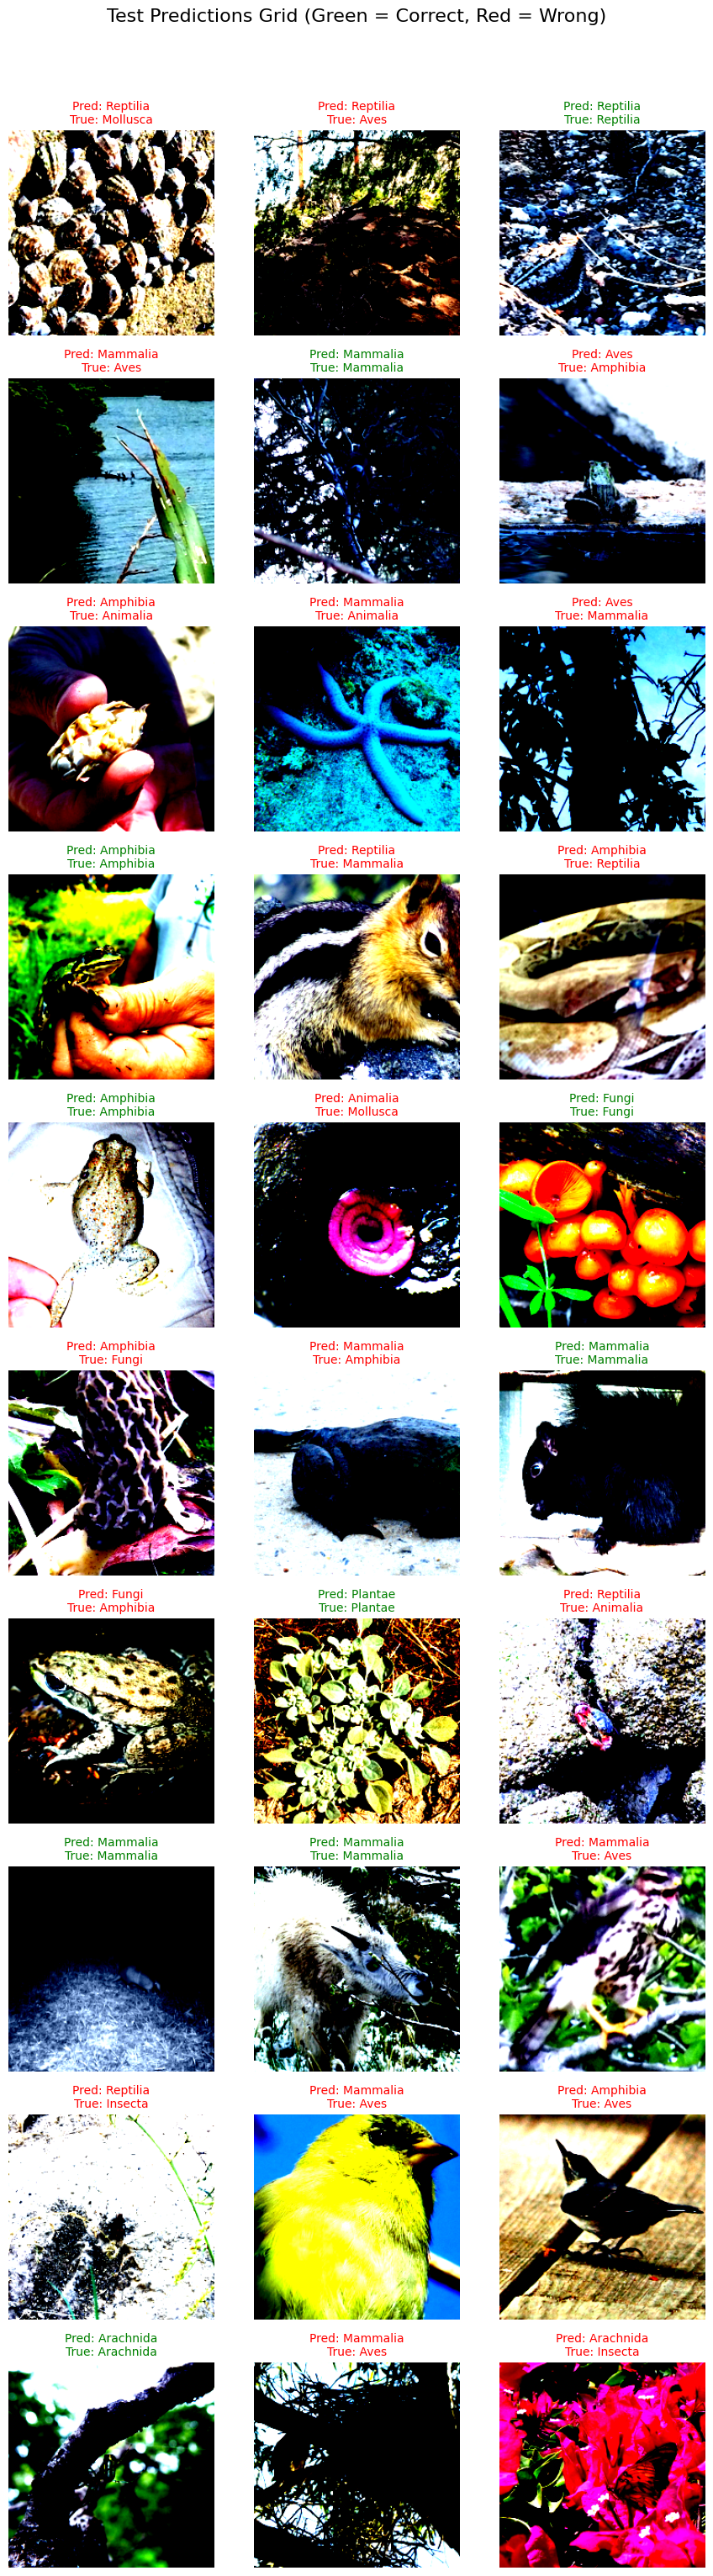

In [49]:
class_names = test_loader.dataset.classes
show_predictions_grid(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu',class_names=class_names)